## Train temporal models for mortality risk prediction

## Imports

In [12]:
import os
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics

sys.path.append("..")
sys.path.append("../..")
from cyclops.utils.file import load_dataframe, save_dataframe
from drift_detection.baseline_models.temporal.pytorch.optimizer import Optimizer
from drift_detection.baseline_models.temporal.pytorch.utils import *

## Load train/val/test inputs and labels

In [43]:
DIR = "/mnt/nfs/project/delirium/drift_exp/risk_of_mortality"
DIR = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022/"
split_type = "random"
split_type = "covid"
X_train = np.load(os.path.join(DIR, split_type, "X_train.npy"))
X_val = np.load(os.path.join(DIR, split_type, "X_val.npy"))
X_test = np.load(os.path.join(DIR, split_type, "X_test.npy"))

y_train = np.load(os.path.join(DIR, split_type, "y_train.npy"))
y_val = np.load(os.path.join(DIR, split_type, "y_val.npy"))
y_test = np.load(os.path.join(DIR, split_type, "y_test.npy"))

print("Train set size:", X_train.shape[0])
print("Val set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

print("Num features:", X_train.shape[2])

Train set size: 13015
Val set size: 3254
Test set size: 1099
Num features: 108
(13015, 6, 108) (3254, 6, 108) (1099, 6, 108)


## Model and training configuration

In [44]:
output_dim = 1
batch_size = 64
input_dim = X_train.shape[2]
timesteps = X_train.shape[1]
hidden_dim = 64
layer_dim = 2
dropout = 0.2
n_epochs = 256
learning_rate = 2e-3
weight_decay = 1e-6
last_timestep_only = False

device = get_device()

X_train_inputs = X_train
X_val_inputs = X_val
X_test_inputs = X_test

train_dataset = get_data(X_train_inputs, y_train)
train_loader = train_dataset.to_loader(batch_size, shuffle=True)

val_dataset = get_data(X_val_inputs, y_val)
val_loader = val_dataset.to_loader(batch_size)

model_params = {
    "device": device,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "layer_dim": layer_dim,
    "output_dim": output_dim,
    "dropout_prob": dropout,
    "last_timestep_only": last_timestep_only,
}

model = get_temporal_model("lstm", model_params).to(device)
model

LSTMModel(
  (lstm): LSTM(108, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Training and validation

[1/256] Training loss: 0.6104	 Validation loss: 0.5888
[2/256] Training loss: 0.5755	 Validation loss: 0.5730
[3/256] Training loss: 0.5603	 Validation loss: 0.5622
[4/256] Training loss: 0.5481	 Validation loss: 0.5545
[5/256] Training loss: 0.5397	 Validation loss: 0.5477
[6/256] Training loss: 0.5341	 Validation loss: 0.5435
[7/256] Training loss: 0.5285	 Validation loss: 0.5405
[8/256] Training loss: 0.5247	 Validation loss: 0.5379
[9/256] Training loss: 0.5216	 Validation loss: 0.5358
[10/256] Training loss: 0.5192	 Validation loss: 0.5345
[11/256] Training loss: 0.5173	 Validation loss: 0.5319
[12/256] Training loss: 0.5150	 Validation loss: 0.5301
[13/256] Training loss: 0.5125	 Validation loss: 0.5288
[14/256] Training loss: 0.5105	 Validation loss: 0.5275
[15/256] Training loss: 0.5090	 Validation loss: 0.5276
[16/256] Training loss: 0.5091	 Validation loss: 0.5263
[17/256] Training loss: 0.5067	 Validation loss: 0.5247
[18/256] Training loss: 0.5061	 Validation loss: 0.5234
[

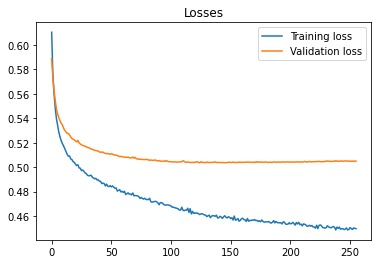

In [45]:
loss_fn = nn.BCEWithLogitsLoss(reduction="none")
optimizer = optim.Adagrad(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=128, gamma=0.5)
activation = nn.Sigmoid()
opt = Optimizer(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    activation=activation,
    lr_scheduler=lr_scheduler,
)
opt.train(
    train_loader,
    val_loader,
    batch_size=batch_size,
    n_epochs=n_epochs,
    n_features=input_dim,
    timesteps=timesteps,
)
opt.plot_losses()

## Val Metrics

In [50]:
val_evaluate_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
y_val_labels, y_val_pred_values, y_val_pred_labels = opt.evaluate(
    val_evaluate_loader, batch_size=1, n_features=input_dim, timesteps=timesteps
)

y_val_pred_values = y_val_pred_values[y_val_labels != -1]
y_val_pred_labels = y_val_pred_labels[y_val_labels != -1]
y_val_labels = y_val_labels[y_val_labels != -1]

confusion_matrix = metrics.confusion_matrix(y_val_labels, y_val_pred_labels)
print(confusion_matrix)

pred_metrics = print_metrics_binary(y_val_labels, y_val_pred_values, y_val_pred_labels)
prec = (pred_metrics["prec0"] + pred_metrics["prec1"]) / 2
rec = (pred_metrics["rec0"] + pred_metrics["rec1"]) / 2
print(f"Precision: {prec}")
print(f"Recall: {rec}")

[[9782 1292]
 [2762 2805]]
confusion matrix:
[[9782 1292]
 [2762 2805]]
accuracy = 0.7563848495483398
precision class 0 = 0.7798150777816772
precision class 1 = 0.6846473217010498
recall class 0 = 0.8833303451538086
recall class 1 = 0.5038620233535767
AUC of ROC = 0.8012392601996614
AUC of PRC = 0.67758512683843
min(+P, Se) = 0.6267504488330341
Precision: 0.7322311997413635
Recall: 0.6935961842536926


## Testing, metrics

In [51]:
test_dataset = get_data(X_test_inputs, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
    test_loader, batch_size=1, n_features=input_dim, timesteps=timesteps
)

y_pred_values = y_pred_values[y_test_labels != -1]
y_pred_labels = y_pred_labels[y_test_labels != -1]
y_test_labels = y_test_labels[y_test_labels != -1]

confusion_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels)
print(confusion_matrix)

pred_metrics = print_metrics_binary(y_test_labels, y_pred_values, y_pred_labels)
prec = (pred_metrics["prec0"] + pred_metrics["prec1"]) / 2
rec = (pred_metrics["rec0"] + pred_metrics["rec1"]) / 2
print(f"Precision: {prec}")
print(f"Recall: {rec}")

[[2932  247]
 [1284 1038]]
confusion matrix:
[[2932  247]
 [1284 1038]]
accuracy = 0.7216869592666626
precision class 0 = 0.6954458951950073
precision class 1 = 0.8077821135520935
recall class 0 = 0.9223026037216187
recall class 1 = 0.44702842831611633
AUC of ROC = 0.803191717068759
AUC of PRC = 0.7586217683746967
min(+P, Se) = 0.6722652885443583
Precision: 0.751613974571228
Recall: 0.6846655011177063


## Plot confusion matrix

In [48]:
def plot_confusion_matrix(confusion_matrix, class_names):
    confusion_matrix = (
        confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
    )

    layout = {
        "title": "Confusion Matrix",
        "xaxis": {"title": "Predicted value"},
        "yaxis": {"title": "Real value"},
    }

    fig = go.Figure(
        data=go.Heatmap(
            z=confusion_matrix,
            x=class_names,
            y=class_names,
            hoverongaps=False,
            colorscale="Greens",
        ),
        layout=layout,
    )
    fig.update_layout(height=512, width=1024)
    fig.show()


plot_confusion_matrix(
    confusion_matrix, ["low risk of mortality", "high risk of mortality"]
)

## Compute AUROC across timesteps

In [49]:
y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
    test_loader, batch_size=1, n_features=input_dim, timesteps=timesteps, flatten=False
)

num_timesteps = y_pred_labels.shape[1]
auroc_timesteps = []
for i in range(num_timesteps):
    labels = y_test_labels[:, i]
    pred_vals = y_pred_values[:, i]
    preds = y_pred_labels[:, i]
    pred_vals = pred_vals[labels != -1]
    preds = preds[labels != -1]
    labels = labels[labels != -1]
    pred_metrics = print_metrics_binary(labels, pred_vals, preds, verbose=False)
    auroc_timesteps.append(pred_metrics["auroc"])


prediction_hours = list(range(24, 168, 24))
fig = go.Figure(
    data=[go.Bar(x=prediction_hours, y=auroc_timesteps, name="model confidence")]
)

fig.update_xaxes(tickvals=prediction_hours)
fig.update_yaxes(range=[min(auroc_timesteps) - 0.05, max(auroc_timesteps) + 0.05])

fig.update_layout(
    title="AUROC split by no. of hours after admission",
    autosize=False,
    xaxis_title="No. of hours after admission",
)
fig.show()

## WIP: Compute accuracy across lead times

In [ ]:
# BASE_DATA_PATH = "/mnt/nfs/project/delirium/drift_exp/risk_of_mortality"

# combined_events = load_dataframe(os.path.join(BASE_DATA_PATH, "combined_events"))
# timestep_end_timestamps = load_dataframe(os.path.join(BASE_DATA_PATH, "aggmeta_end_ts"))

# mortality_events = combined_events.loc[combined_events["event_name"] == "death"]

# y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
#     test_loader, batch_size=1, n_features=input_dim, timesteps=timesteps, flatten=False
# )
# train_val_test_ids = load_dataframe(os.path.join(BASE_DATA_PATH, "train_val_test_ids"))
# test_ids = train_val_test_ids["test"].dropna()

# num_timesteps = y_pred_labels.shape[1]
# acc_timesteps = []
# for timestep in range(num_timesteps):
#     labels = y_test_labels[:, timestep]
#     pred_vals = y_pred_values[:, timestep]
#     preds = y_pred_labels[:, timestep]

#     is_correct_timestep = []
#     for enc_id in test_ids:
#         timestep_end_timestamp = timestep_end_timestamps.loc[enc_id, timestep]
#         mortality_timestamp = mortality_events.loc[mortality_events["encounter_id"] == enc_id]["discharge_timestamp"]
#         lead_time = mortality_timestamp - timestep_end_timestamp
#         print(timestep_end_timestamp, mortality_timestamp)
#         if (lead_time > pd.to_timedelta(0, unit="h")).all():
#             label_ = labels[test_ids.index(enc_id)]
#             pred_ = preds[test_ids.index(enc_id)]

#             if label_ == 1:
#                 if label_ == pred_:
#                     is_correct_timestep.append(1)
#                 else:
#                     is_correct_timestep.append(0)

#     acc_timesteps.append(sum(is_correct_timestep) / len(is_correct_timestep))

## Visualize model outputs and labels

In [ ]:
def plot_risk_mortality(predictions, labels=None):
    prediction_hours = list(range(24, 168, 24))
    is_mortality = labels == 1
    after_discharge = labels == -1
    label_h = -0.2
    fig = go.Figure(
        data=[
            go.Scatter(
                mode="markers",
                x=prediction_hours,
                y=[label_h for x in prediction_hours],
                line=dict(color="Black"),
                name="low risk of mortality label",
                marker=dict(color="Green", size=20, line=dict(color="Black", width=2)),
            ),
            go.Scatter(
                mode="markers",
                x=[prediction_hours[i] for i, v in enumerate(is_mortality) if v],
                y=[label_h for _, v in enumerate(is_mortality) if v],
                line=dict(color="Red"),
                name="high risk of mortality label",
                marker=dict(color="Red", size=20, line=dict(color="Black", width=2)),
            ),
            go.Scatter(
                mode="markers",
                x=[prediction_hours[i] for i, v in enumerate(after_discharge) if v],
                y=[label_h for _, v in enumerate(after_discharge) if v],
                line=dict(color="Grey"),
                name="post discharge label",
                marker=dict(color="Grey", size=20, line=dict(color="Black", width=2)),
            ),
            go.Bar(
                x=prediction_hours,
                y=predictions,
                marker_color="Red",
                name="model confidence",
            ),
        ]
    )
    fig.update_yaxes(range=[label_h, 1])
    fig.update_xaxes(tickvals=prediction_hours)
    fig.update_xaxes(showline=True, linewidth=2, linecolor="black")

    fig.add_hline(y=0.5)

    fig.update_layout(
        title="Model output visualization",
        autosize=False,
        xaxis_title="No. of hours after admission",
        yaxis_title="Model confidence",
    )

    return fig


mortality_cases = [idx for idx, v in enumerate(y_test_labels)]
sample_idx = random.choice(mortality_cases)
fig = plot_risk_mortality(
    y_pred_values[sample_idx].squeeze(), y_test_labels[sample_idx]
)
fig.show()

## Journal of some experiments

In [50]:
### Val Metrics (covid)

[[9782 1292]
 [2762 2805]]
confusion matrix:
[[9782 1292]
 [2762 2805]]
accuracy = 0.7563848495483398
precision class 0 = 0.7798150777816772
precision class 1 = 0.6846473217010498
recall class 0 = 0.8833303451538086
recall class 1 = 0.5038620233535767
AUC of ROC = 0.8012392601996614
AUC of PRC = 0.67758512683843
min(+P, Se) = 0.6267504488330341
Precision: 0.7322311997413635
Recall: 0.6935961842536926


In [51]:
### Test Metrics (covid)

[[2932  247]
 [1284 1038]]
confusion matrix:
[[2932  247]
 [1284 1038]]
accuracy = 0.7216869592666626
precision class 0 = 0.6954458951950073
precision class 1 = 0.8077821135520935
recall class 0 = 0.9223026037216187
recall class 1 = 0.44702842831611633
AUC of ROC = 0.803191717068759
AUC of PRC = 0.7586217683746967
min(+P, Se) = 0.6722652885443583
Precision: 0.751613974571228
Recall: 0.6846655011177063


In [ ]:
### Val Metrics (seasonal)

[[3575  606]
 [ 977  932]]
confusion matrix:
[[3575  606]
 [ 977  932]]
accuracy = 0.7400656938552856
precision class 0 = 0.7853690981864929
precision class 1 = 0.6059817671775818
recall class 0 = 0.8550586104393005
recall class 1 = 0.4882137179374695
AUC of ROC = 0.7499390154442839
AUC of PRC = 0.5656325748774201
min(+P, Se) = 0.560376372190277
Precision: 0.6956754326820374
Recall: 0.671636164188385


In [36]:
### Test Metrics (seasonal)

[[13601  2411]
 [ 4608  3906]]
confusion matrix:
[[13601  2411]
 [ 4608  3906]]
accuracy = 0.7138139009475708
precision class 0 = 0.7469383478164673
precision class 1 = 0.6183314919471741
recall class 0 = 0.8494254350662231
recall class 1 = 0.45877379179000854
AUC of ROC = 0.7276978290770999
AUC of PRC = 0.5793506812041425
min(+P, Se) = 0.5755226685459244
Precision: 0.6826349496841431
Recall: 0.6540995836257935


In [50]:
### Val Metrics (covid)

[[6393  717]
 [1549 1212]]
confusion matrix:
[[6393  717]
 [1549 1212]]
accuracy = 0.7704386711120605
precision class 0 = 0.8049609661102295
precision class 1 = 0.6283048391342163
recall class 0 = 0.8991560935974121
recall class 1 = 0.4389714002609253
AUC of ROC = 0.7895631385721659
AUC of PRC = 0.6116704744660759
min(+P, Se) = 0.563787495482472
Precision: 0.7166329026222229
Recall: 0.6690637469291687


In [42]:
#Test Metrics (hosp type)

[[13490  2178]
 [ 6870  5545]]
confusion matrix:
[[13490  2178]
 [ 6870  5545]]
accuracy = 0.6778122186660767
precision class 0 = 0.6625736951828003
precision class 1 = 0.717985212802887
recall class 0 = 0.8609905242919922
recall class 1 = 0.4466371238231659
AUC of ROC = 0.7313315996825387
AUC of PRC = 0.6916549001198892
min(+P, Se) = 0.6353898195876289
Precision: 0.690279483795166
Recall: 0.6538138389587402



<table>
    <thead>
        <tr>
            <th>Split</th>
            <th>Model</th>
            <th>AUROC</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=4>Random</td>
        </tr>
        <tr>
            <td>LSTM</td>
            <td><b>0.8005</b></td>
        </tr>
          <tr style="border-bottom:1px solid black">
            <td colspan="100%"></td>
          </tr>
          <tr> ... </tr>
    </tbody>
</table>